In [3]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.linalg import sqrtm
from skimage.transform import resize

# ml libraries
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, Concatenate, Multiply, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


## Create data generator

In [4]:
# data set
# https://drive.google.com/drive/folders/1WocxvZ4GEZ1DI8dOz30aSj2zT6pkATYS   thumbnails128x128.zip
trainSet = pd.read_csv('dataset/train.csv', header=None).to_numpy()
trainSet = trainSet.reshape(len(trainSet),)
testSet = pd.read_csv('dataset/test.csv', header=None).to_numpy()
testSet = testSet.reshape(len(testSet),)

def dataGenerator(data, batchSize):
  while True:
    imageBatch = np.random.choice(data, batchSize, replace = False)
    images = []
    for image in imageBatch:
        folderName = 'thumbnails/'
        image = folderName + image.split('/')[-1]
        images.append((np.array(Image.open(image))/127.5) - 1)
    yield np.array(images)

In [10]:
_, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, d in enumerate(dataGenerator(trainSet, 1)):
    axs[i].imshow(d[0]*0.5+0.5)
    if(i == 1):
        break

Generator

In [3]:
# https://github.com/gusgad/capsule-GAN
# generator structure
def capsGANGenerator():

    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """
    noise_shape = (150,)
    x_noise = Input(shape=noise_shape)

    firstLayer = Dense(512 * 8 * 8, activation="relu")(x_noise) #8x8
    firstLayer = Reshape((8, 8, 512))(firstLayer)
    firstLayer = BatchNormalization(momentum=0.8)(firstLayer)
    firstLayer = UpSampling2D()(firstLayer) #16x16

    secondLayer = Conv2D(256, kernel_size=3, padding="same")(firstLayer) 
    secondLayer = Activation("relu")(secondLayer)
    secondLayer = BatchNormalization(momentum=0.8)(secondLayer)
    secondLayer = UpSampling2D()(secondLayer) #32x32

    thirdLayer = Conv2D(256, kernel_size=3, padding="same")(secondLayer) 
    thirdLayer = Activation("relu")(thirdLayer)
    thirdLayer = BatchNormalization(momentum=0.8)(thirdLayer)
    thirdLayer = UpSampling2D()(thirdLayer) #64x64

    fourthLayer = Conv2D(128, kernel_size=3, padding="same")(thirdLayer) 
    fourthLayer = Activation("relu")(fourthLayer)
    fourthLayer = BatchNormalization(momentum=0.8)(fourthLayer)
    fourthLayer = UpSampling2D()(fourthLayer) #128x128

    fifthLayer = Conv2D(64, kernel_size=3, padding="same")(fourthLayer) 
    fifthLayer = Activation("relu")(fifthLayer)
    fifthLayer = BatchNormalization(momentum=0.8)(fifthLayer)
    sixthLayer = Conv2D(3, kernel_size=3, padding="same")(fifthLayer) 
    outputLayer = Activation("tanh")(sixthLayer)
    return Model(x_noise, outputLayer)

In [4]:
# build and compile the generator
generator = capsGANGenerator()
print('GENERATOR:')
generator.summary()








GENERATOR:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             4947968   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       1179904   
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0  

Discriminator

In [7]:
# squash function of capsule layers, borrowed from Xifeng Guo's implementation of Keras CapsNet `https://github.com/XifengGuo/CapsNet-Keras`
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

def capsGANDiscriminator():
    img = Input((128,128,3))
    # first conv layer outputs a 128x128x256 matrix
    firstLayer = Conv2D(filters=256, kernel_size=9, strides=1, padding='same', name='conv1')(img)
    firstLayer = LeakyReLU()(firstLayer)
    firstLayer = BatchNormalization(momentum=0.8)(firstLayer)

    secondLayer = Conv2D(filters=256, kernel_size=9, strides=2, padding='same', name='conv2')(firstLayer)
    secondLayer = LeakyReLU()(secondLayer)
    secondLayer = BatchNormalization(momentum=0.8)(secondLayer)

    thirdLayer = Conv2D(filters=256, kernel_size=9, strides=2, padding='same', name='conv3')(secondLayer)
    thirdLayer = LeakyReLU()(thirdLayer)
    thirdLayer = BatchNormalization(momentum=0.8)(thirdLayer)

    """
    NOTE: Capsule architecture starts from here.
    """
    # primarycaps
    # filters 256 (n_vectors=8 * channels=32)
    primaryCapsuleLayer = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(thirdLayer)

    # reshape into the 8D vector for all 32 feature maps combined
    # (primary capsule has collections of activations which denote orientation of the digit
    # while intensity of the vector which denotes the presence of the digit)
    primaryCapsuleLayer = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(primaryCapsuleLayer)

    # the purpose is to output a number between 0 and 1 for each capsule where the length of the input decides the amount
    primaryCapsuleLayer = Lambda(squash, name='primarycap_squash')(primaryCapsuleLayer)
    primaryCapsuleLayer = BatchNormalization(momentum=0.8)(primaryCapsuleLayer)

    #
    # digitcaps are here
    #
    """
    NOTE: My approach is a simplified version of digitcaps i.e. without expanding dimensions into
    [None, 1, input_n_vectors, input_dim_capsule (feature maps)]
    and tiling it into [None, num_capsule, input_n_vectors, input_dim_capsule (feature maps)].
    Instead I replace it with ordinary Keras Dense layers as weight holders in the following lines.

    ANY CORRECTIONS ARE APPRECIATED IN THIS PART, PLEASE SUBMIT PULL REQUESTS!
    """
    digitCaps = Flatten()(primaryCapsuleLayer)
    # capsule (i) in a lower-level layer needs to decide how to send its output vector to higher-level capsules (j)
    # it makes this decision by changing scalar weight (c=coupling coefficient) that will multiply its output vector and then be treated as input to a higher-level capsule
    #
    # uhat = prediction vector, w = weight matrix but will act as a dense layer, u = output from a previous layer
    # uhat = u * w
    # neurons 160 (num_capsules=10 * num_vectors=16)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(digitCaps)

    # c = coupling coefficient (softmax over the bias weights, log prior) | "the coupling coefficients between capsule (i) and all the capsules in the layer above sum to 1"
    # we treat the coupling coefficiant as a softmax over bias weights from the previous dense layer
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one

    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    firstCapsuleLayer = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(firstCapsuleLayer)


    #
    # we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    #
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    secondCapsuleLayer = Multiply()([uhat, c])
    s_j = LeakyReLU()(secondCapsuleLayer)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    thirdCapsuleLayer = Multiply()([uhat, c])
    s_j = LeakyReLU()(thirdCapsuleLayer)

    pred = Dense(1, activation='sigmoid')(s_j)
    return Model(img, pred)

In [8]:
# build and compile the discriminator
discriminator = capsGANDiscriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

DISCRIMINATOR:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 256 62464       input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128, 128, 256 0           conv1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128, 256 1024        leaky_re_lu_7[0][0]              
______________________________________________________________________________________________

Creating Capsule GAN

In [10]:
def createCapsGAN(generator, discriminator):
    z = Input((150,))
    genImage = generator(z)
    discriminator.trainable = False
    valid = discriminator(genImage)
    return Model(z, valid)

generator = load_model('CapsGanGen_model.h5')
discriminator = load_model('CapsGanDisc_model.h5')

capsGAN = createCapsGAN(generator, discriminator)
print('Capsule GAN:')
capsGAN.summary()
capsGAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

Capsule GAN:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150)               0         
_________________________________________________________________
model_2 (Model)              (None, 128, 128, 3)       7093379   
_________________________________________________________________
model_1 (Model)              (None, 1)                 21967425  
Total params: 29,060,804
Trainable params: 7,090,947
Non-trainable params: 21,969,857
_________________________________________________________________


Utility methods

In [17]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)    # resize with nearest neighbor interpolation
        images_list.append(new_image) # store
    return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(images1, images2):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight) :  # Weight between 0 and 1
    if not scalars: return
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed
  
# https://realpython.com/python-csv/
def plotGraph(filename, smoothingFactor):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        graph = []
        for row in csv_reader:
            for column in row:
                graph.append(float(column))
    graph = smooth(graph, smoothingFactor)
    plt.plot(graph)
    return

def calculate_fidLarge(modelToTest, totalImages, numberOfImagesPerIteration, testSet):
    numberOfIterations = int(totalImages/numberOfImagesPerIteration)
    generationActs = []
    testActs = []
#     print(numberOfIterations)
    for i in range(numberOfIterations):
        print(i)
        generatedImage = modelToTest.predict(np.random.normal(0, 1, (numberOfImagesPerIteration, 150)))
        testImages = np.array([(np.array(Image.open(i))/127.5) - 1 for i in np.random.choice(testSet, numberOfImagesPerIteration, replace = False)])
        model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
        images1 = generatedImage.astype('float32')
        images2 = testImages.astype('float32')
        images1 = scale_images(images1, (299,299,3))
        images2 = scale_images(images2, (299,299,3))
        # calculate activations
        act1 = model.predict(images1)
        for act in act1:
            generationActs.append(act)
        act2 = model.predict(images2)
        for act in act2:
            testActs.append(act)
    generationActs = np.array(generationActs)
    testActs = np.array(testActs)
    # calculate mean and covariance statistics
    mu1, sigma1 = generationActs.mean(axis=0), np.cov(generationActs, rowvar=False)
    mu2, sigma2 = testActs.mean(axis=0), np.cov(testActs, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

Training the model

In [ ]:
%%time
# Training Capsule GAN
batchSize = 32
iteration = 1750
epochs = 10
discriminatorLossArray, CapsGanGeneratorLoss = [], []

real = np.ones((batchSize, 1))
fake = np.zeros((batchSize, 1))
noiseInputTest = np.random.normal(0, 1, (1, 150))
for epoch in range(epochs):
    for i, d in enumerate(dataGenerator(trainSet, batchSize)):
        noiseInput = np.random.normal(0, 1, (batchSize, 150))
        generatedImage = generator.predict(noiseInput)
        
        discriminatorLossReal = discriminator.train_on_batch(d, real*0.9) # 0.9 for label smoothing
        discriminatorLossFake = discriminator.train_on_batch(generatedImage, fake)
        discriminatorLoss = 0.5* np.add(discriminatorLossReal , discriminatorLossFake)
        discriminatorLossArray.append(discriminatorLoss[0])
        
        noiseInput = np.random.normal(0, 1, (batchSize, 150))
        CapsGan_loss = capsGAN.train_on_batch(noiseInput, real)
        CapsGanGeneratorLoss.append(CapsGan_loss)
        if((i+1)%10 == 0):
            print("Epoch: " + str(epoch+1)+"/"+ str(epochs) + " iteration: "+ str(i+1) +"/"+ str(iteration)+ " D Loss: "+ str(discriminatorLoss[0])+ " D acc: "+ str(discriminatorLoss[1]*100) + " CapsGAN Loss: "+ str(CapsGan_loss))
        if(i == iteration-1):
            break
    if (epoch+1) % 2 == 0:
        generatedImage = generator.predict(np.random.normal(0, 1, (100, 150)))
        fid = calculate_fid(generatedImage, np.array([(np.array(Image.open(i))/127.5) - 1 for i in np.random.choice(testSet, 100, replace = False)]))
        print('FID : %.3f' % fid)
        with open('discriminatorLossFile.csv', mode='a') as discriminatorLossFile:
            discriminatorLossFile_writer = csv.writer(discriminatorLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            discriminatorLossFile_writer.writerow(discriminatorLossArray)
            discriminatorLossArray = []
        with open('CapsGanLossFile.csv', mode='a') as CapsGanLossFile:
            CapsGanLossFile_writer = csv.writer(CapsGanLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            CapsGanLossFile_writer.writerow(CapsGanGeneratorLoss)
            CapsGanGeneratorLoss = []
        with open('FIDScore.csv', mode='a') as FIDScoreFile:
            FIDScoreFileFile_writer = csv.writer(FIDScoreFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            FIDScoreFileFile_writer.writerow([fid])
        generator.save('CapsGanGen_model.h5')
        discriminator.save('CapsGanDisc_model.h5')

Graphs (Discriminator Loss, Generator Loss and FID Score during Training)

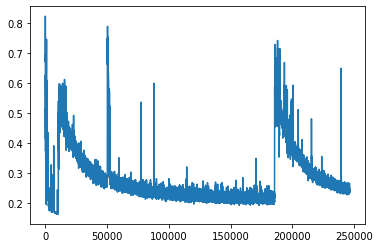

In [13]:
plotGraph('discriminatorLossFile.csv', 0.95)

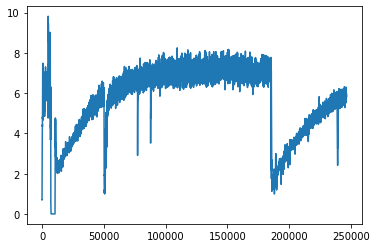

In [14]:
plotGraph('CapsGanLossFile.csv', 0.95)

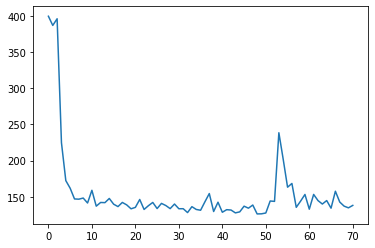

In [15]:
plotGraph('FIDScore.csv', 0)

FID Score evaluation

In [18]:
%%time
fid = calculate_fidLarge(generator, 50000, 1000, testSet)
print('FID: '+str(fid))

Show generated images

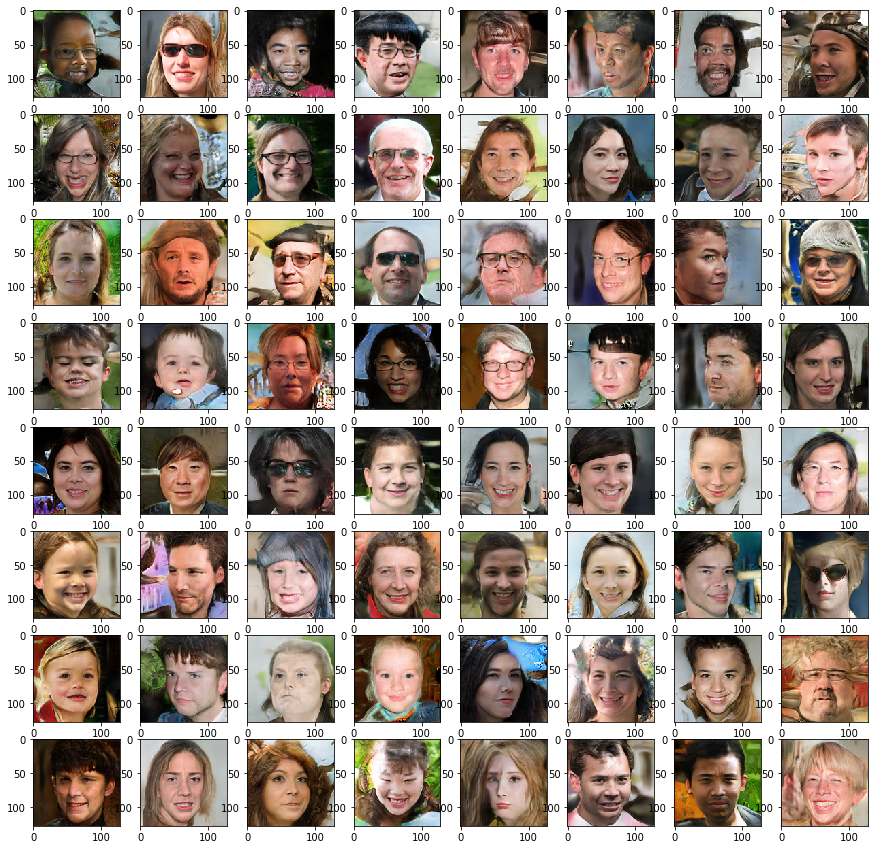

In [20]:
_, axs = plt.subplots(8, 8, figsize=(15, 15))

noiseInputTest = np.random.normal(0, 1, (64, 150))
# noiseInputTest[0][23] = 0.1
generatedImage = generator.predict(noiseInputTest)
generatedImage = (generatedImage*0.5 + 0.5).reshape(64,128, 128, 3)
for i in range(8):
  for j in range(8):
    axs[i][j].imshow(generatedImage[i*8+j])